In [1]:
import os
import csv
import pandas as pd

In [2]:
# takes all .txt files located in a directory, retrieves their file sizes, and writes the filenames along with their respective sizes into a CSV file located at some dir.

directory = "/Users/daniel24/Documents/Research/SMHD/SMHD_raw_and_cleaned_texts"

output_csv = "/Users/daniel24/Documents/Research/SMHD/file_sizes_diagnosed_texts.csv"

# Function to get file sizes in the directory
def get_file_sizes(directory):
    file_sizes = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            size = os.path.getsize(file_path)
            file_sizes.append((filename, size))
    return file_sizes

# Write file sizes to CSV
def write_to_csv(file_sizes, output_csv):
    with open(output_csv, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Filename', 'Filesize'])
        csv_writer.writerows(file_sizes)

# Get file sizes
file_sizes = get_file_sizes(directory)

# Write to CSV
write_to_csv(file_sizes, output_csv)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/daniel24/Documents/Research/SMHD/SMHD_raw_and_cleaned_texts'

In [4]:
#### NOTE From Cohan et al paper: 
# Control users post on average twice as many posts as diagnosed users, but these posts tend to be considerably shorter. Although this may be a valid signal for certain mental health conditions, it can be removed for classification experiments by truncating the length and number of posts. This is common practice for technical reasons, and truncating post length has been shown in previous work to improve classification performance (Yates et al., 2017).
# Each user’s posts are concatenated and truncated to 15,000 tokens. This representation combines tractability with density.

# Get the distributions of the file sizes ()
# combine multiple CSV files into one DataFrame, splits the 'Filename' column into 'ID', 'post', and 'MHC' columns using underscores, and exports the result to a CSV file.

results_directory = "/Users/daniel24/Documents/Research/SMHD/TextsFileSizeTest"
output_csv = "/Users/daniel24/Documents/Research/SMHD/TextsFileSizeTest/filesize_distribution.csv"

# Read in the two results files and concatenate them into one DataFrame
results_df_list = []
for filename in os.listdir(results_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(results_directory, filename)
        df = pd.read_csv(file_path)
        results_df_list.append(df)

# Concatenate the DataFrames
concatenated_df = pd.concat(results_df_list, ignore_index=True)

# Split the filename into three columns (ID, post, MHC)
concatenated_df[['ID', 'post', 'MHC']] = concatenated_df['Filename'].str.split('_', expand=True)


# Write the concatenated DataFrame to a CSV file
concatenated_df.to_csv(output_csv, index=False)


In [15]:
# Remove '.txt' from MHC column
concatenated_df['MHC'] = concatenated_df['MHC'].str.replace('.txt', '')

In [16]:
concatenated_df.head()

,Filename,Filesize,ID,post,MHC
0,6840898_11_bipolar.txt,79,6840898.0,11,bipolar
1,2653817_4_depression.txt,44,2653817.0,4,depression
2,2059773_53_bipolar.txt,477,2059773.0,53,bipolar
3,5751547_90_bipolar.txt,9,5751547.0,90,bipolar
4,2486860_18_depression.txt,241,2486860.0,18,depression


In [19]:
# Filter concatenated_df to get rows with filesize smaller than 50
filtered_filenames = concatenated_df.loc[concatenated_df['Filesize'] < 50, 'Filename'].tolist()

filtered_filenames_df = pd.DataFrame({'Filename': filtered_filenames})
filtered_filenames_df['Filename'] = filtered_filenames_df['Filename'].str.replace('.txt', '')

# Save the IDs to a file
filtered_filenames_df.to_csv('/Users/daniel24/Documents/Research/SMHD/TextsFileSizeTest/short_file_ids.csv', index=False)


In [24]:
filtered_filenames_df['Filename'] = filtered_filenames_df['Filename'].str.replace('.txt', '')

,Filename
0,2653817_4_depression
1,5751547_90_bipolar
2,8870753_4_depression
3,9138077_103_bipolar
4,1655578_77_anxiety


In [12]:
# Compute descriptive statistics of filesize per MHC
stats_df = concatenated_df.groupby('MHC')['Filesize'].describe()

# Count the number of files with a filesize of less than 50kb per MHC
file_counts_df = concatenated_df[concatenated_df['Filesize'] < 50 ].groupby('MHC')['Filesize'].count().reset_index()
file_counts_df.columns = ['MHC', 'Files Less than 50KB']

# Merge the descriptive statistics and file counts DataFrames
result_df = pd.merge(stats_df, file_counts_df, on='MHC', how='left')

result_df['Proportion Below Threshold'] = result_df['Files Less than 50KB'] / result_df['count']
result_df = result_df[result_df['MHC'] != 'nan']
# Display the result DataFrame
result_df.head()


,MHC,count,mean,std,min,25%,50%,75%,max,Files Less than 50KB,Proportion Below Threshold
0,anxiety,199961.0,226.493446,394.222456,1.0,39.0,108.0,260.0,16253.0,59683,0.298473
1,bipolar,160400.0,230.420530,471.009829,1.0,38.0,103.0,252.0,28969.0,49515,0.308697
2,control,1529555.0,128.382737,254.117888,1.0,24.0,60.0,141.0,19219.0,673559,0.440363
3,depression,346782.0,223.214189,412.424379,1.0,38.0,103.0,249.0,37883.0,106028,0.305748


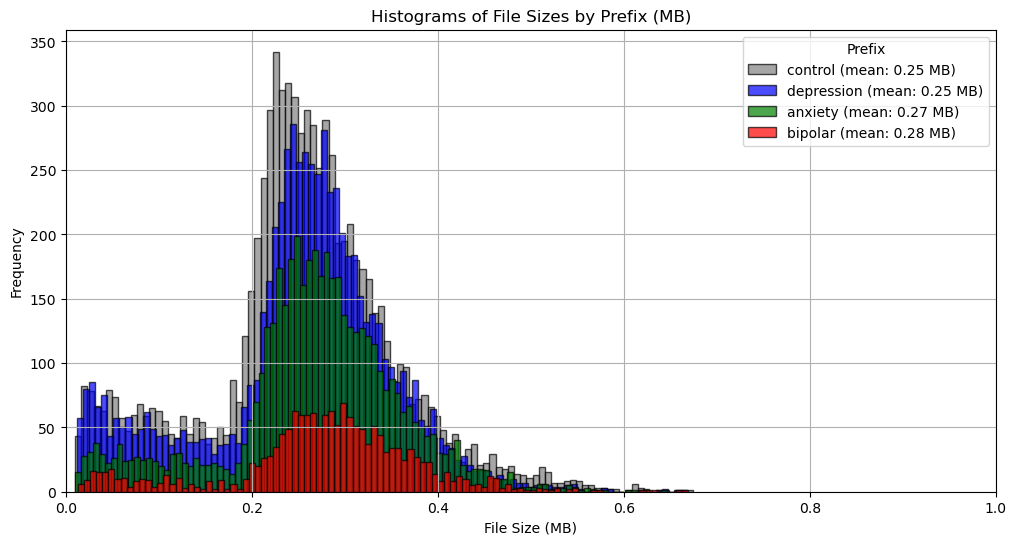

In [29]:
import os
import matplotlib.pyplot as plt

# Directory containing the CSV files
directory = '/Users/daniel24/Documents/Research/datasets/TwitterSTMHD/0_CSVcollective_copy'

# Dictionary to hold file size data
file_sizes = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        prefix = filename.split('_')[0]
        size = os.path.getsize(os.path.join(directory, filename)) / 1e6  # Convert bytes to megabytes
        if prefix not in file_sizes:
            file_sizes[prefix] = []
        file_sizes[prefix].append(size)

# Number of bins for histograms
bins = 100  # Increased the number of bins for more detail

# Create a single figure to plot histograms
plt.figure(figsize=(12, 6))
plt.title('Histograms of File Sizes by Prefix (MB)')

# Colors for each prefix (optional, for better visualization)
colors = ['grey', 'blue', 'green', 'red']  # Ensure 'control' uses a less prominent color
prefix_order = sorted(file_sizes.keys(), key=lambda x: (x != 'control'))  # 'control' comes first

# Plot histograms for each sorted prefix
for prefix in prefix_order:
    sizes = file_sizes[prefix]
    plt.hist(sizes, bins=bins, alpha=0.7, color=colors[prefix_order.index(prefix) % len(colors)], edgecolor='black', label=f'{prefix} (mean: {sum(sizes)/len(sizes):.2f} MB)')

# Add legend to identify prefixes
plt.legend(title='Prefix')
plt.xlabel('File Size (MB)')
plt.ylabel('Frequency')
plt.grid(True)

# Limit the x-axis to 100 MB
plt.xlim([0, 1])

# Show plot
plt.show()
